In [45]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#@author: Kelle Clark, Andrew Florian, Xinyu Xiong
#Created on Tue Feb  4 10:05:49 2020
#CSCI 6040 Project 1 Text Generation
#PHASE 3: Smoothing the Language Models for the Corpus

#Various folders of .txt files were created in the CSCI6040 Team Project 1 folder
#to be used for testing our application during develpment
#/Short Test Data
# has 3 .txt files each about 4KB
#/Med test Data 
# has 2 .txt files one of 119KB (Tragedy of Macbeth) and 6.5MB (big)
#/Grande test Data (the 18-document-gutenburg-copus but with 19? files cleaned using the 
#boilerplate.ipynb -author Andrew Florian and resulting files 
#shared on Canvas in Project 1 discussion forum)
# has 19 .txt files with a total of 11.8MB

In [46]:
#we needed the help of a few packages...import all those at once
import langid
import itertools 
import nltk
import numpy
import os
import pandas
import random
import re
import string
import sys
from collections import Counter
from math import log10
from matplotlib.pyplot import yscale, xscale, title, plot
from nltk.tokenize import word_tokenize, sent_tokenize

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM
#from keras.utils import np_utils
#from keras.callbacks import ModelCheckpoint


In [47]:
#**** from phase 1 reading in the tokenized corpus

def tokensByFiles(folderpath):
    textfiles = [f for f in os.listdir(folderpath) if '.txt' in f]
    tokenfilelist =[]
    
    for f in textfiles:
            rawcorpus = []
            substring = ''
            file = open(folderpath+"/"+f,'rt', encoding='utf-8', errors='replace')                                   
            print (f"     Reading from: '{f}' . . .")
            rawcorpus.append(file.read()
                     .replace('. . .','.')
                     .replace('!',' .')  # substitue space period for ! mark to have a simple token to end a sentence 
                     .replace('"',' ')
                     .replace('#',' ')  
                     .replace('$',' ')
                     .replace('%',' ')
                     .replace('&',' ')
                     .replace('\\',' ') 
                     .replace('\' ',' ')  # only remove ' if it has a space before or after meaning it is used as a quote
                     .replace(' \'',' ')  # but leave it in if it is inside a word as a contraction
                     .replace('\- ',' ')  # only remove - if it has a space before or after meaning it is to be left in the 
                     .replace(' \-',' ')  # word e.g. C-A-T
                     .replace('(',' ')
                     .replace('\n', ' ')        
                     .replace(')',' ')
                     .replace('*',' ')
                     .replace('+',' ')
                     .replace(',',' ')
                     .replace('. ',' ')  
                     .replace('/',' ')                 
                     .replace(':',' ')
                     .replace(';',' ')
                     .replace('<',' ')
                     .replace('=',' ')
                     .replace('>',' ')
                     .replace('?',' .')  # substitue space period for ? mark to have a simple token to end a sentence
                     .replace('@',' ')
                     .replace('[',' ')
                     .replace('\\',' ')
                     .replace(']',' ')
                     .replace('^',' ')
                     .replace('_',' ')   #  remove all unwanted punctuation
                     .replace('`',' ')
                     .replace('{',' ')
                     .replace('|',' ')
                     .replace('}',' ')
                     .replace('~',' ')
                     .replace('0',' ')   #  remove all digits
                     .replace('1',' ')
                     .replace('2',' ')
                     .replace('3',' ')
                     .replace('4',' ')
                     .replace('5',' ')                
                     .replace('6',' ')
                     .replace('7',' ')
                     .replace('8',' ')
                     .replace('9',' '))            
            file.close()
            
            substring = substring + rawcorpus[0]
            #print(f"the language of file "+f+" is {nltk.language(substring)}")
            print(f"the estimated language of the file {f} is {langid.classify(substring)}")
            
            #tokens=substring.split()
            tokens = word_tokenize(substring)
            tokens = [w.lower() for w in tokens]
            tokenfilelist.append(tokens)
             
    return tokenfilelist


#we have the different files tokenized, in the variable tokenfilelist
#method below creates one corpus from the string of tokens in each file 
def createOneCorpus(inlist):
    temp = " "
    for i in range(len(inlist)):
        for w in inlist[i]:
            temp = temp + w + " "
    return temp

def printcorpus(instring):
    if len(instring) > 500: 
        print(f"The first & last 50 tokens of this corpus are:\n  {instring[:50]} \t ... {instring[-50:]}\n")
    else:
        print(f"The tokens in the corpus are: \n {instring} \n")

#ngrams returns a dictionary
# enumerate ngrams code copied from Eisentein and CSCI6040 ipynb
# returns the ngram from instring and n
def ngrams(instring, n):
    outset = {}
    for i in range(len(instring) - n + 1):
        g = ' '.join(instring[i:i+n])
        outset.setdefault(g, 0)
        outset[g] += 1
    return outset        


In [48]:
#**** from phase 1 reading in the .txt files and creating the tokenized corpus
pathname = 'Test Data/short test data'
#pathname = 'your choice of path here'

#read in the corups file by file
tokenfilelist = tokensByFiles(pathname)
#print(tokenfilelist)

tokencorpus = createOneCorpus(tokenfilelist)
#printcorpus(tokencorpus)
tokens = tokencorpus.split()

     Reading from: 'Testset1.txt' . . .
the estimated language of the file Testset1.txt is ('en', -112.47618627548218)
     Reading from: 'Testset2.txt' . . .
the estimated language of the file Testset2.txt is ('en', -757.8414204120636)
     Reading from: 'Testset3.txt' . . .
the estimated language of the file Testset3.txt is ('en', -295.17291164398193)


The sum of all the probabiities of unigrams needs to be 1 and it is 1.0000000000000009

Number of rows in Unigram Prob. Model :  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
the unigram of greatest freq is: do 

The sum of all the probabiities for bigrams needs to be 1 and it is 0.9894736842105274
Number of rows in Bigram Prob. Model :  87
               prob.
the cat     0.010526
cat named   0.010526
named bob   0.010526
bob is      0.021053
is damn     0.010526
...              ...
not exist   0.010526
exist on    0.010526
earth dogs  0.010526
dogs are    0.010526
are the     0.010526

[87 rows x 1 columns]
the bigram of greatest freq  is: are the 

The sum of all the probabiities for trigrams needs to be 1 and it is 0.9789473684210537
Number of rows in Trigram Prob. Model :  91
                   prob

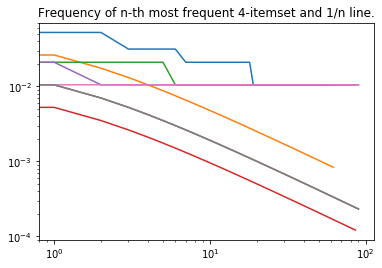

In [49]:
#**** from phase 2 creating the four different language models using ngrams:
#unigram prob. model using prob(x) = (frequency of x in corpus)/(total in corpus)
def createUnigramModel(instring):
    n = 1
    outset = word_tokenize(instring)

    totalpossible = len(outset)
    sumofprob = 0
    
    anoutcome = ngrams(outset,n)
    probmodel = anoutcome
  
    for keyword in anoutcome:
        probmodel[keyword] = (anoutcome[keyword]) / totalpossible
        sumofprob = sumofprob + probmodel[keyword]
    
    print(f"The sum of all the probabiities of unigrams needs to be 1 and it is {sumofprob}\n")
    return probmodel
 
#create the unigram model 
unigrammodel = createUnigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
unidataframe = pandas.DataFrame.from_dict(unigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Unigram Prob. Model : ', len(unidataframe.index))
print(unidataframe)

#Attempt to try and plot the unigram language model using first a Counter object
COUNT = Counter(unigrammodel)
greatestprob = 0
bigword = ''
for w in COUNT.keys():
    if COUNT[w] >= greatestprob:
        bigword = w
        greatestprob = COUNT[w]
        
print(f"the unigram of greatest freq is: {bigword} \n")
M = COUNT[bigword]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent word and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##UNIGRAMS, WE COULD USE PROB. M/i for the ith rankend term and M is the frequency of the
##MOST COMMON UNIGRAM
plot([c for (w,c) in COUNT.most_common()])
plot([M/i for i in range(1, len(COUNT)+1)]);

#method to create the bigram model
def createBigramModel(instring):
    n = 2
    outset = word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,n)
    previousoutcome = ngrams(outset,n-1)
    sumofprob = 0
    
    probmodel = anoutcome
       
    for keyword in anoutcome:
        listword = keyword.split()
        prob1 = (previousoutcome[listword[0]]) / totalpossible
        probmodel[keyword] = prob1 * ((probmodel[keyword]) / (previousoutcome[listword[0]]))
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities for bigrams needs to be 1 and it is {sumofprob}")
    return probmodel  


#create the bigram model
bigrammodel = createBigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
bidataframe = pandas.DataFrame.from_dict(bigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Bigram Prob. Model : ', len(bidataframe.index))
print(bidataframe)

#Attempt to try and plot the bigram language model using first a Counter object
COUNT2 = Counter(bigrammodel)
greatestprob2 = 0
bigword2 = ''
for w in COUNT2.keys():
    if COUNT2[w] >= greatestprob2:
        bigword2 = w
        greatestprob2 = COUNT[w]
        
print(f"the bigram of greatest freq  is: {bigword2} \n")
M2 = COUNT2[bigword2]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 2-itemset and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##BIGRAMS, WE COULD USE PROB. M/i for the ith rankend term and M is the frequency of the
##MOST COMMON BIGRAM
plot([c for (w,c) in COUNT2.most_common()])
plot([(M2)/i for i in range(1, len(COUNT2)+1)]);


#create the trigram model
def createTrigramModel(instring):
    n = 3
    outset = word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,3)
    probmodel = anoutcome
    sumofprob = 0
    
    previous1outcome = ngrams(outset,n-2)
    previous2outcome = ngrams(outset,n-1)
    
    for keyword in anoutcome:    
        listword = keyword.split()
        wordofinterest = listword[0]
        prob1 = previous1outcome[wordofinterest]/ totalpossible
           
        wordofinterest = listword[0] + " " + listword[1]
        prob2 = previous2outcome[wordofinterest]/previous1outcome[listword[0]] 
           
        wordofinterest = keyword
        probmodel[keyword] = prob1 * prob2 * anoutcome[wordofinterest]/ previous2outcome[listword[0]+ " " + listword[1]]
        sumofprob = sumofprob + probmodel[keyword]
        
    print(f"The sum of all the probabiities for trigrams needs to be 1 and it is {sumofprob}")
    return probmodel  

#create the trigram model
trigrammodel = createTrigramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
tridataframe = pandas.DataFrame.from_dict(trigrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Trigram Prob. Model : ', len(tridataframe.index))
print(tridataframe)

#Attempt to plot the trigram language model using first a Counter object
COUNT3 = Counter(trigrammodel)
greatestprob3 = 0
bigword3 = ''
for w in COUNT3.keys():
    if COUNT3[w] >= greatestprob3:
        bigword3 = w
        greatestprob3 = COUNT3[w]
        
print(f"the trigram of greatest freq  is: {bigword3} \n")
M3 = COUNT3[bigword3]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 3-itemset and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##TRIGRAMS, WE COULD USE PROB. M3/i for the ith rankend term and M3 is the frequency of the
##MOST COMMON TRIGRAM
plot([c for (w,c) in COUNT3.most_common()])
plot([(M3)/i for i in range(1, len(COUNT3)+1)]);

#create the quadgram model
def createQuadgramModel(instring):
    n = 4
    outset = word_tokenize(instring)
    totalpossible = len(outset)
   
    anoutcome = ngrams(outset,n)
    probmodel = anoutcome   
    sumofprob = 0
   
    previous1outcome = ngrams(outset,n-3)
    previous2outcome = ngrams(outset,n-2)
    previous3outcome = ngrams(outset,n-1)
  
    for keyword in anoutcome:       
        listword = keyword.split()
        wordofinterest = listword[0]
        prob1 = previous1outcome[wordofinterest]/ totalpossible
           
        wordofinterest = listword[0] + " " + listword[1]
        prob2 = previous2outcome[wordofinterest]/previous1outcome[listword[0]] 
           
        wordofinterest = listword[0]+ " " + listword[1] + " " + listword[2]
        prob3 = previous3outcome[wordofinterest]/previous2outcome[listword[0] + " " + listword[1]]
           
        wordofinterest = keyword
        probmodel[keyword] = prob1 * prob2 * prob3 * anoutcome[wordofinterest]/ previous3outcome[listword[0]+ " " + listword[1] + " "+ listword[2]]
        sumofprob = sumofprob + probmodel[keyword]
           
    print(f"The sum of all the probabiities of quadgrams needs to be 1 and it is {sumofprob}")
    return probmodel  

#create the quadgram model
quadgrammodel = createQuadgramModel(tokencorpus)


pandas.set_option("display.max_rows", 10)
quaddataframe = pandas.DataFrame.from_dict(quadgrammodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Quadgram Prob. Model : ', len(quaddataframe.index))
print(quaddataframe)

#Attempt to plot the trigram language model using first a Counter object
COUNT4 = Counter(quadgrammodel)
greatestprob4 = 0
bigword4 = ''
for w in COUNT4.keys():
    if COUNT4[w] >= greatestprob4:
        bigword4 = w
        greatestprob4 = COUNT4[w]
        
print(f"the quadgram of greatest freq is: {bigword4} \n")
M4 = COUNT4[bigword4]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 4-itemset and 1/n line.')
##RAN INTO SOME ISSUES GETTING THE GRAPH TO PRINT THE RANK ORDER OF THE WORDS...
##BUT WHAT I THINK THIS IS SHOWING IS THAT IF WE WANT TO SMOOTH THE PROB. MODEL FOR
##QUADGRAMS, WE COULD USE PROB. M4/i for the ith rankend term and M3 is the frequency of the
##MOST COMMON TRIGRAM
plot([c for (w,c) in COUNT4.most_common()])
plot([(M4)/i for i in range(1, len(COUNT4)+1)]);

In [60]:
#### from phase 2, The team kept both ngrams method and newngram method for computing the 
###unigrams, bigrams, trigrams and quadgrams smoothed models....
###output of newngram is a Counter obj and output of ngrams is a dictionary object...

#newngram outputs to files:
#the most common unigrams are set to unigramfile.dat
#the most common bigrams are set to bigramfile.dat
#the most common trigrams are set to trigramfile.dat
#the most common quadgrams are set to quadgramfile.dat

#!!!newngram now returns a string 
def newngram(toks, n):
    output = {}   
    for i in range(len(toks) - n + 1):
        g = ' '.join(toks[i:i+n])
        output.setdefault(g, 0)
        output[g] += 1
    COUNTS = Counter(output)
    outputstring = ''
    outputstring = outputstring + str(COUNTS.most_common(3000)) + " "
    if n == 1:
        #print(f"\n   The most common unigrams are: {(COUNTS.most_common(10))}")
        f=open("unigramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(3000))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(3000)) + " "
        f.close()
    if n == 2:
        #print(f"\n   The most common bigrams are: {(COUNTS.most_common(10))}")
        f=open("bigramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2700))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(2700)) + " "
        f.close()
    if n == 3:
        #print(f"\n The most common trigrams are: {(COUNTS.most_common(10))}")
        f=open("trigramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2300))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(2300)) + " "
        f.close()
    if n == 4:
        #print(f"\n   The most common quadgrams are: {(COUNTS.most_common(10))}")
        f=open("quadgramfile.dat","w+", encoding='utf-8', errors='replace')
        f.write(str(sum(COUNTS.values())))
        f.write(str(COUNTS.most_common(2100))) #trying to keep file size at about 50 k for this sample
        outputstring = outputstring + str(COUNTS.most_common(2100)) + " "
        f.close()
    
    return outputstring

###!!!! THESE COUNTS WILL BE USED IN THE TEXT GENERATION METHOD BELOW...THE PHASE 3 LAPLACE SMOOTH
###!!! MODELS ARE CREATED IMPLICITLY WITHIN THE GENERATING TEXT MODULE
unigramsstring = newngram(tokens, 1)
#print(unigramsstring)
bigramsstring = newngram(tokens, 2)
#print(bigramsstring)
trigramsstring = newngram(tokens, 3)
#print(trigramsstring)
quadgramsstring = newngram(tokens, 4)
#print(quadgramsstring)



lamd:  [1]
Number of rows in Linear Smoothed Unigram Prob. Model :  63
           prob.
the     0.052632
cat     0.021053
named   0.010526
bob     0.021053
is      0.052632
...          ...
cats    0.010526
should  0.010526
not     0.010526
exist   0.010526
dogs    0.010526

[63 rows x 1 columns]
the unigram of greatest freq in the smoothed unigram model is: do 

lamd:  [0.9518435776829439, 0.04815642231705608]
Number of rows in Linear Smoothed Bigram Prob. Model :  87
               prob.
the cat     0.050097
cat named   0.020039
named bob   0.010019
bob is      0.020039
is damn     0.050097
...              ...
not exist   0.010019
exist on    0.010019
earth dogs  0.020039
dogs are    0.010019
are the     0.020039

[87 rows x 1 columns]
the bigram of greatest freq in the linear smoothed bigram model is: is better 

lamd:  [0.01873462891976918, 0.8774545141137076, 0.10381085696652326]
Number of rows in Linear Smoothed Trigram Prob. Model :  91
                   prob.
the cat named   

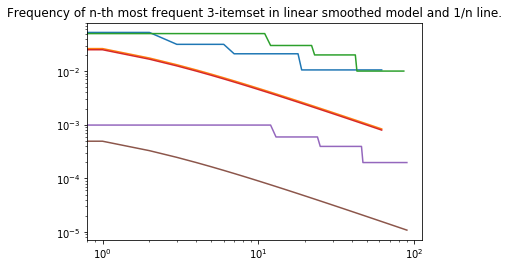

In [61]:
####****KEPT IN PHASE 4 TO PROVIDE COMPARISON IN EVALUATION TEXT GENERATION IN PHASE 5..
####****from phase 3 were we create new models of the language using the linear smoothing and weightings lambda
####****the linear smoothing quadgram model has minor error in indexing and should be updated.
#smoothing the ngramModel using a linear function of the kgrams for k = 1 to n
def ngramModel_LinearSmooth(inlist, n):
    #generate ngrams
    total = len(inlist)
    anoutcome = []
    for i in range(1,n+1):
        anoutcome.append(ngrams(inlist, i))
        #print("outcome: ")
        #print(anoutcome[i-1])
        
    #generate lamd coefficients for terms in model
    k = 1
    lamd = []
    last_lamd = 0
    for i in range(1,n):
        lamd.append(random.uniform(0,k))
        k = k-lamd[i -1]              
    lamd.append(k)
    print("lamd: ", lamd)
    #generate smooth model
    smooth_model = {}
    for keyword in anoutcome[n-1]:
        grams = keyword.split(' ')
        #print("grams:")
        #print(grams)
        smooth_model.setdefault(keyword, lamd[0]*anoutcome[0][grams[0]]/total)
        for i in range(1,len(grams) - 2):
            sub_string = ' '.join(grams[0:i])
            sub_sub_string = ' '.join(input[0:i -1])
           # print(sub_string)
            smooth_model[keyword] = smooth_model[keyword] + lamd[i] * (anoutcome[i][sub_string]/anoutcome[i-1][keyword])
        #print(keyword + ":")
        #print(smooth_model[keyword])
    #print("smooth_model:")
    #print(smooth_model)
    return smooth_model

linearsmoothunimodel = ngramModel_LinearSmooth(tokens, 1)

pandas.set_option("display.max_rows", 10)
linearsmoothunidataframe = pandas.DataFrame.from_dict(linearsmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Unigram Prob. Model : ', len(linearsmoothunidataframe.index))
print(linearsmoothunidataframe)

#Attempt to plot the unigram language model using first a Counter object
COUNTLSMOOTH1 = Counter(linearsmoothunimodel)
greatestlinearsmoothprob1 = 0
biglinearsmoothword1 = ''
for w in COUNTLSMOOTH1.keys():
    if COUNTLSMOOTH1[w] >= greatestlinearsmoothprob1:
        biglinearsmoothword1 = w
        greatestlinearsmoothprob1 = COUNTLSMOOTH1[w]
        
print(f"the unigram of greatest freq in the smoothed unigram model is: {biglinearsmoothword1} \n")
MLS1 = COUNTLSMOOTH1[biglinearsmoothword1]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 1-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH1.most_common()])
plot([(MLS1)/i for i in range(1, len(COUNTLSMOOTH1)+1)]);

linearsmoothbimodel = ngramModel_LinearSmooth(tokens, 2)

pandas.set_option("display.max_rows", 10)
linearsmoothbidataframe = pandas.DataFrame.from_dict(linearsmoothbimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Bigram Prob. Model : ', len(linearsmoothbidataframe.index))
print(linearsmoothbidataframe)

#Attempt to plot the bigram language model using first a Counter object
COUNTLSMOOTH2 = Counter(linearsmoothbimodel)
greatestlinearsmoothprob2 = 0
biglinearsmoothword2 = ''
for w in COUNTLSMOOTH2.keys():
    if COUNTLSMOOTH2[w] >= greatestlinearsmoothprob2:
        biglinearsmoothword2 = w
        greatestlinearsmoothprob2 = COUNTLSMOOTH2[w]
        
print(f"the bigram of greatest freq in the linear smoothed bigram model is: {biglinearsmoothword2} \n")
MLS2 = COUNTLSMOOTH2[biglinearsmoothword2]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 2-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH2.most_common()])
plot([(MLS2)/i for i in range(1, len(COUNTLSMOOTH1)+1)]);

linearsmoothtrimodel = ngramModel_LinearSmooth(tokens, 3)

pandas.set_option("display.max_rows", 10)
linearsmoothtridataframe = pandas.DataFrame.from_dict(linearsmoothtrimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Linear Smoothed Trigram Prob. Model : ', len(linearsmoothtridataframe.index))
print(linearsmoothtridataframe)

#Attempt to plot the trigram language model using first a Counter object
COUNTLSMOOTH3 = Counter(linearsmoothtrimodel)
greatestlinearsmoothprob3 = 0
biglinearsmoothword3 = ''
for w in COUNTLSMOOTH3.keys():
    if COUNTLSMOOTH3[w] >= greatestlinearsmoothprob3:
        biglinearsmoothword3 = w
        greatestlinearsmoothprob3 = COUNTLSMOOTH3[w]
        
print(f"the trigram of greatest freq in the smoothed trigram model is: {biglinearsmoothword3} \n")
MLS3 = COUNTLSMOOTH3[biglinearsmoothword3]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 3-itemset in linear smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLSMOOTH3.most_common()])
plot([(MLS3)/i for i in range(1, len(COUNTLSMOOTH3)+1)]);

#linearsmoothquadmodel = ngramModel_LinearSmooth(tokens, 4)

#pandas.set_option("display.max_rows", 10)
#linearsmoothquaddf = pandas.DataFrame.from_dict(linearsmoothquadmodel, orient = 'index', columns = ['prob.'])
#print('Number of rows in Linear Smoothed Quadgram Prob. Model : ', len(linearsmoothquaddf.index))
#print(linearsmoothquaddf)

##Attempt to plot the quadgram language model using first a Counter object
#COUNTLSMOOTH4 = Counter(linearsmoothquadmodel)
#greatestlinearsmoothprob4 = 0
#biglinearsmoothword4 = ''
#for w in COUNTLSMOOTH4.keys():
#    if COUNTLSMOOTH4[w] >= greatestlinearsmoothprob4:
#        biglinearsmoothword4 = w
#        greatestlinearsmoothprob4 = COUNTLSMOOTH4[w]
        
#print(f"the quadgram of greatest freq in the smoothed quadgram model is: {biglinearsmoothword4} \n")
#MLS4 = COUNTLSMOOTH4[biglinearsmoothword4]
#yscale('log'); xscale('log'); title('Frequency of n-th most frequent 4-itemset in linear smoothed model and 1/n line.')

#plot([c for (w,c) in COUNTLSMOOTH4.most_common()])
#plot([(MLS4)/i for i in range(1, len(COUNTLSMOOTH4)+1)]);

In [62]:
####****from phase 3, the next cell below uses in the smoothing of the language models with Laplace...
#In case we want to take into consideration of the file size when smoothing
#the language models... we created a Counter object for each file to seperate
#the unigrams, bigrams, trigrams and quadgrams in each file and their fruency in the file...
#the createListDoc_Foo_Counters below take in a list of strings, one fore each incoming file, which we
#created when we read in the files ....the smoothing in the Laplace smoothing below do not weight
#the files by size but do use these counters to tally up the total freqeuencies of ngrams and token count
def createListDocUniCounter(inlist):
    docfreqlist = []
    for i in range(len(inlist)):
        counter = Counter(newngram(inlist[i],1))
        docfreqlist.append(counter)
    return docfreqlist

dfforuniperfile = createListDocUniCounter(tokenfilelist)
firstunifile = dfforuniperfile[0]
#print(dfforuniperfile)
#print(firstunifile)

def createListDocBiCounter(inlist):
    df = []
    for i in range(len(inlist)):
        #words = re.findall("\w+",inlist[i])
        counter = Counter(newngram(inlist[i],2))
        df.append(counter)
    return df

dfforbiperfile = createListDocBiCounter(tokenfilelist)
firstbifile = dfforbiperfile[0]
#print(firstbifile)
#print(dfforbiperfile)

def createListDocTriCounter(inlist):
    df = []
    for i in range(len(inlist)):
        #words = re.findall("\w+",inlist[i])
        counter = Counter(newngram(inlist[i],3))
        df.append(counter)
    return df

dffortriperfile = createListDocTriCounter(tokenfilelist)
firsttrifile = dffortriperfile[0]
#print(firsttrifile)
#print(dffortriperfile)

def createListDocQuadCounter(inlist):
    df = []
    for i in range(len(inlist)):
        #words = re.findall("\w+",inlist[i])
        counter = Counter(newngram(inlist[i],4))
        df.append(counter)
    return df

dfforquadperfile = createListDocQuadCounter(tokenfilelist)
firstquadfile = dfforquadperfile[0]
#print(firstquadfile)
#print(dfforquadperfile)

The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is 0.9999999999999991
Number of rows in Laplace Smoothed Unigram Prob. Model :  63
           prob.
the     0.028169
cat     0.017606
named   0.014085
bob     0.017606
is      0.028169
...          ...
cats    0.014085
should  0.014085
not     0.014085
exist   0.014085
dogs    0.014085

[63 rows x 1 columns]
the unigram of greatest freq in the Laplace smoothed unigram model is: is 

Number of rows in Laplace Smoothed Bigram Prob. Model :  87
               prob.
the cat     0.011331
cat named   0.011331
named bob   0.011331
bob is      0.014164
is damn     0.011331
...              ...
not exist   0.011331
exist on    0.011331
earth dogs  0.011331
dogs are    0.011331
are the     0.011331

[87 rows x 1 columns]
the bigram of greatest freq in the Laplace smoothed bigram model is: do we 

Number of rows in Laplace Smoothed Trigram Prob. Model :  91
                  prob.
the cat named   0.01105
ca

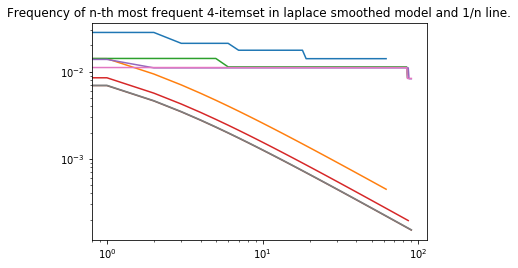

In [53]:
###****From Phase 3 of the project the Laplace smoothed unigram, bigram, trigram and quadgram models
###****using the chosen training data test folder....relies on computation of the above module for the dataframes
###****per file
#Laplace smoothed unigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedUnigramModel(outset, dfperfilelist):
    n = 1   
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
       
        
    #print(f"The laplaceprobmodel is \n {laplaceprobmodel}")
    print(f"The sum of all the unigram probabiities in the laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

laplacesmoothunimodel = createLeplaceSmoothedUnigramModel(tokens, dfforuniperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothunidf = pandas.DataFrame.from_dict(laplacesmoothunimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Unigram Prob. Model : ', len(laplacesmoothunidf.index))
print(laplacesmoothunidf)

#Attempt to plot the unigram language model using first a Counter object
COUNTLapSMOOTH1 = Counter(laplacesmoothunimodel)
greatestlaplacesmoothprob1 = 0
biglaplacesmoothword1 = ''
for w in COUNTLapSMOOTH1.keys():
    if COUNTLapSMOOTH1[w] >= greatestlaplacesmoothprob1:
        biglaplacesmoothword1 = w
        greatestlaplacesmoothprob1 = COUNTLapSMOOTH1[w]
        
print(f"the unigram of greatest freq in the Laplace smoothed unigram model is: {biglaplacesmoothword1} \n")
MLapS1 = COUNTLapSMOOTH1[biglaplacesmoothword1]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 1-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH1.most_common()])
plot([(MLapS1)/i for i in range(1, len(COUNTLapSMOOTH1)+1)]);

#Laplace smoothed bigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedBigramModel(outset, dfperfilelist):
    n = 2    
    anoutcome = ngrams(outset,n)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            #print(keyword, count[keyword], filecount)
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the probabiities needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

laplacesmoothbimodel = createLeplaceSmoothedBigramModel(tokens, dfforbiperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothbidf = pandas.DataFrame.from_dict(laplacesmoothbimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Bigram Prob. Model : ', len(laplacesmoothbidf.index))
print(laplacesmoothbidf)

#Attempt to plot the bigram language model using first a Counter object
COUNTLapSMOOTH2 = Counter(laplacesmoothbimodel)
greatestlaplacesmoothprob2 = 0
biglaplacesmoothword2 = ''
for w in COUNTLapSMOOTH2.keys():
    if COUNTLapSMOOTH2[w] >= greatestlaplacesmoothprob2:
        biglaplacesmoothword2 = w
        greatestlaplacesmoothprob2 = COUNTLapSMOOTH2[w]
        
print(f"the bigram of greatest freq in the Laplace smoothed bigram model is: {biglaplacesmoothword2} \n")
MLapS2 = COUNTLapSMOOTH2[biglaplacesmoothword2]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 2-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH2.most_common()])
plot([(MLapS2)/i for i in range(1, len(COUNTLapSMOOTH2)+1)]);

#Laplace smoothed trigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedTrigramModel(outset, dfperfilelist):
    n = 3   
    anoutcome = ngrams(outset,3)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            #print(keyword, count[keyword], filecount)
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the trigram probabiities in the Laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

laplacesmoothtrimodel = createLeplaceSmoothedTrigramModel(tokens, dffortriperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothtridf = pandas.DataFrame.from_dict(laplacesmoothtrimodel, orient = 'index', columns = ['prob.'])
print('Number of rows in Laplace Smoothed Trigram Prob. Model : ', len(laplacesmoothtridf.index))
print(laplacesmoothtridf)

#Attempt to plot the trigram language model using first a Counter object
COUNTLapSMOOTH3 = Counter(laplacesmoothtrimodel)
greatestlaplacesmoothprob3 = 0
biglaplacesmoothword3 = ''
for w in COUNTLapSMOOTH3.keys():
    if COUNTLapSMOOTH3[w] >= greatestlaplacesmoothprob3:
        biglaplacesmoothword3 = w
        greatestlaplacesmoothprob3 = COUNTLapSMOOTH3[w]
        
print(f"the trigram of greatest freq in the Laplace smoothed trigram model is: {biglaplacesmoothword3} \n")
MLapS3 = COUNTLapSMOOTH3[biglaplacesmoothword3]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 3-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH3.most_common()])
plot([(MLapS3)/i for i in range(1, len(COUNTLapSMOOTH3)+1)]);

#Laplace smoothed trigram prob. model using prob(x) = (1 + frequency of x in corpus)/(total in corpus)
def createLeplaceSmoothedQuadgramModel(outset, dfperfilelist):
    n = 4  
    anoutcome = ngrams(outset,4)
    sumoflaplaceprob = 0
  
    laplaceprobmodel = anoutcome
    
    for w in laplaceprobmodel:
        laplaceprobmodel[w] = 0
  
    filecount = 0
    for temp in anoutcome:
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            filecount = filecount + count[temp] + 1
            
    for keyword in anoutcome:
        #print(keyword)
        for i in range(len(dfperfilelist)):
            count = dfperfilelist[i]
            #print(keyword, count[keyword], filecount)
            laplaceprobmodel[keyword] = laplaceprobmodel[keyword] + (count[keyword] + 1)/(filecount) 
            #print(laplaceprobmodel[keyword], keyword)
        sumoflaplaceprob = sumoflaplaceprob + laplaceprobmodel[keyword]
        #print(sumoflaplaceprob)
    
    #print(f"The laplaeprobmodel is \n {laplaceprobmodel}")
    #print(f"The sum of all the quadgram probabiities in the Laplace smoothed model needs to be 1 and it is {sumoflaplaceprob}")
    return laplaceprobmodel    

laplacesmoothquadmodel = createLeplaceSmoothedQuadgramModel(tokens, dfforquadperfile)

pandas.set_option("display.max_rows", 10)
laplacesmoothquaddf = pandas.DataFrame.from_dict(laplacesmoothquadmodel, orient = 'index', columns = ['prob.'])

print('Number of rows in Laplace Smoothed Quadgram Prob. Model : ', len(laplacesmoothquaddf.index))
print(laplacesmoothquaddf)

#Attempt to plot the quadgram language model using first a Counter object
COUNTLapSMOOTH4 = Counter(laplacesmoothquadmodel)
greatestlaplacesmoothprob4 = 0
biglaplacesmoothword4 = ''

for w in COUNTLapSMOOTH4.keys():
    if COUNTLapSMOOTH4[w] >= greatestlaplacesmoothprob4:
        biglaplacesmoothword4 = w
        greatestlaplacesmoothprob4 = COUNTLapSMOOTH4[w]
        
print(f"the quadgram of greatest freq in the Laplace smoothed quadgram model is: {biglaplacesmoothword4} \n")
MLapS4 = COUNTLapSMOOTH4[biglaplacesmoothword4]
yscale('log'); xscale('log'); title('Frequency of n-th most frequent 4-itemset in laplace smoothed model and 1/n line.')

plot([c for (w,c) in COUNTLapSMOOTH4.most_common()])
plot([(MLapS4)/i for i in range(1, len(COUNTLapSMOOTH4)+1)]);



In [63]:
ranint = random.randint(0,len(laplacesmoothunimodel)-1)
print(ranint)

27


In [64]:
####***** if you are feeling like generating a random seed for the text:
i = 0;
lapcounter = Counter(laplacesmoothunimodel)
ranint = random.randint(0, len(laplacesmoothunimodel)-1)
for w in laplacesmoothunimodel.keys():
    if (i == ranint):
        seedword = w
    i = i + 1
print(seedword)

####**** to set the seed to one of the most common 10 unigrams:
seedpossibilities = lapcounter.most_common(10)
ranint = random.randint(0,9)
seedtuple = seedpossibilities[ranint]
seedword = seedtuple[0]
print(seedword)

on
damn


In [68]:
####****Finally Phase 4! Here is the geneartion method.  In the cell above,
####****you created a seedword for generating the text...either from the most frequent 10
####****unigramsstring or a random unigram...
print(unigramsstring)
words = unigramsstring.replace('[','').replace(']','').replace('(','').replace(')','').replace('\'','').split(',')
print(words)
unigramrange = 0
for w in range(1,len(words)-1,2):
    unigramrange += int(words[w])

def generate(seedtext, length):
    
    print("Scroll down for the final result.  Here is the process used:\n")
    #five cases: length = 0, length = 1; length = 2; length = 3 or length > 3
    if length == 0:
        output = ''
        
    for gword in range(1,length+1):
        
        if gword == 1:                     # check seedtext
            for char in range(0,len(seedtext)):
                maybe = seedtext[:len(seedtext)-char]
                print(f"\t Searching unigramsstring for '{maybe}'.")        
                if unigramsstring.find(maybe) > -1:
                    if unigramsstring[unigramsstring.find(maybe)-1] == "'":
                        print("            Found the word (or a word that starts with it).")
                        currentword = unigramsstring[unigramsstring.find(maybe):unigramsstring.find("'",
                                    unigramsstring.find(maybe))]
                        break
                    print(f"\t Not found. Dropping a letter")
                    currentword = ""           
                if currentword == "":
                    rand=random.randint(0,newunigramrange)
                    look = rand
                    for w in range(1,len(words)-1,2):
                        look = look - int(words[w])
                        if look < 0:
                            currentword = words[w-1][2:-1]
                            break
                    print(f"\t We randomly choose '{currentword}'.")
                output=currentword
    
        elif gword == 2:                 # use bigram model
            print(f"\t Searching bigrams for '{currentword}'.")        
            bigramoccurance = []
            bigramoccurance.append(bigramsstring.find("'" + currentword + ' '))
            if bigramoccurance[0] > -1:
                possiblebigram = []
                possiblebifrequency = []
                possiblebitotalfreq = 0
                n = 0
                possiblebigram.append(bigrams[bigramoccurance[n]+len(currentword)+2:bigramsstring.find("'",bigramoccurance[n]+len(currentword)+2)])
                try:
                    possiblebifrequency.append(int(bigramsstring[bigramsstring.find("', ",bigramoccurance[n])+3:bigramsstring.find(")",bigramoccurance[n])]))
                    possiblebitotalfreq += possiblebifrequency[n]
                except:
                    print("Error")
                n += 1
                while True:
                    bigramoccurance.append(bigramsstring.find("'" + currentword + ' ', bigramoccurance[n-1]+1))
                    if bigramoccurance[n] == -1: 
                        break
                    possiblebigram.append(bigramsstring[bigramoccurance[n]+len(currentword)+2:bigramsstring.find("'",bigramoccurance[n]+len(currentword)+2)])
                    try:
                        possiblebifrequency.append(int(bigramsstring[bigrams.find("', ",bigramoccurance[n])+3:bigramsstring.find(")",bigramoccurance[n])]))
                        possiblebitotalfreq += possiblebifrequency[n]
                    except:
                        print("Error")
                        break
                n += 1
                rand=random.randint(0,possiblebitotalfreq)
                look = rand
                for w in range(0,n):
                    look = look - possiblebifrequency[w]
                    if look < 0:
                        nextword = possiblebigram[w]
                        break
                    print(f"\t Out of {possiblebitotalfreq} occurances in the bigram model the following word:")
                    for w in range(0,n):
                        print(f"\t '{possiblebigram[w]}' appeared {possiblebifrequency[w]} times,")
                    print(f"\t From the {n} possibilities, we randomly chose '{nextword}'.")                
            else:
                rand=random.randint(0,unigramrange)
                look = rand
                for w in range(1,len(words)-1,2):
                    look = look - int(words[w])
                    if look < 0:
                        nextword = words[w-1][2:-1]
                        break
                    print(f"\t Not found. We randomly choose '{nextword}'.")
                pastword = currentword
                currentword = nextword
                currentbigram = pastword + ' ' + currentword
                output += ' ' + currentword

        elif gword == 3:                 # use trigram model
                print(f"\t Searching trigramsstring for '{currentbigram}'.")        
                trigramoccurance = []
                trigramoccurance.append(trigramsstring.find("'" + currentbigram + ' '))
                if trigramoccurance[0] > -1:
                    possibletrigram = []
                    possibletrifrequency = []
                    possibletritotalfreq = 0
                    n = 0
                    possibletrigram.append(trigramsstring[trigramoccurance[n]+len(currentbigram)+2:trigramsstring.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                    try:
                        possibletrifrequency.append(int(trigramsstring[trigramsstring.find("', ",trigramoccurance[n])+3:trigramsstring.find(")",trigramoccurance[n])]))
                        possibletritotalfreq += possibletrifrequency[n]
                    except:
                        print("Error")
                    n += 1
                    while True:
                        trigramoccurance.append(trigramsstring.find("'" + currentbigram + ' ', trigramoccurance[n-1]+1))
                        if trigramoccurance[n] == -1: break
                        possibletrigram.append(trigramsstring[trigramoccurance[n]+len(currentbigram)+2:trigramsstring.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                        try:
                            possibletrifrequency.append(int(trigramsstring[trigramsstring.find("', ",trigramoccurance[n])+3:trigramsstring.find(")",trigramoccurance[n])]))
                            possibletritotalfreq += possibletrifrequency[n]
                        except:
                            print("Error")
                            break
                        n += 1
                    rand=random.randint(0,possibletritotalfreq)
                    look = rand
                    for w in range(0,n):
                        look = look - possibletrifrequency[w]
                        if look < 0:
                            nextword = possibletrigram[w]
                            break
                    print(f"\t Out of {possibletritotalfreq} occurances in the trigram model the following word:")
                    for w in range(0,n):
                        print(f"\t '{possibletrigram[w]}' appeared {possibletrifrequency[w]} times,")
                    print(f"\t From the {n} possibilities, we randomly chose '{nextword}'.")                             
                else:
                    print(f"\t Not found. Searching bigrams for '{currentword}'.")        
                    bigramoccurance = []
                    bigramoccurance.append(bigramsstring.find("'" + currentword + ' '))
                    if bigramoccurance[0] > -1:
                        possiblebigram = []
                        possiblebifrequency = []
                        possiblebitotalfreq = 0
                        n = 0
                        possiblebigram.append(bigramsstring[bigramoccurance[n]+len(currentword)+2:bigramsstring.find("'",bigramoccurance[n]+len(currentword)+2)])
                        try:
                            possiblebifrequency.append(int(bigramsstring[bigramsstring.find("', ",bigramoccurance[n])+3:bigramsstring.find(")",bigramoccurance[n])]))
                            possiblebitotalfreq += possiblebifrequency[n]
                        except:
                            print("Error")
                        n += 1
                        while True:
                            bigramoccurance.append(bigramsstring.find("'" + currentword + ' ', bigramoccurance[n-1]+1))
                            if bigramoccurance[n] == -1: break
                            possiblebigram.append(bigramsstring[bigramoccurance[n]+len(currentword)+2:bigramsstring.find("'",bigramoccurance[n]+len(currentword)+2)])
                            try:
                                possiblebifrequency.append(int(bigramsstring[bigramsstring.find("', ",bigramoccurance[n])+3:bigramsstring.find(")",bigramoccurance[n])]))
                                possiblebitotalfreq += possiblebifrequency[n]
                            except:
                                print("Error")
                                break
                            n += 1
                        rand = random.randint(0,possiblebitotalfreq)
                        look = rand
                        for w in range(0,n):
                            look = look - possiblebifrequency[w]
                            if look < 0:
                                nextword = possiblebigram[w]
                                break
                        print(f"\t Out of {possiblebitotalfreq} occurances in the bigram model the following word:")
                        for w in range(0,n):
                            print(f"\t '{possiblebigram[w]}' appeared {possiblebifrequency[w]} times,")
                        print(f"\t From the {n} possibilities, we randomly chose '{nextword}'.")                
                    else:
                        rand = random.randint(0,unigramrange)
                        look = rand
                        for w in range(1,len(words)-1,2):
                            look = look - int(words[w])
                            if look < 0:
                                nextword = words[w-1][2:-1]
                                break
                        print(f"\t Not found. We randomly choose '{nextword}'.")
                pastword = currentword
                currentword = nextword
                currenttrigram = currentbigram + ' ' + currentword
                currentbigram = pastword + ' ' + currentword
                output += ' ' + currentword 
  
        else:                     # gword > 3 use quadgram model
            print(f"\t Searching quadigrams for '{currenttrigram}'.")             
            quadgramoccurance = []
            quadgramoccurance.append(quadgramstring.find("'" + currenttrigram + ' '))
            if quadgramoccurance[0] > -1:
                possiblequadgram = []
                possiblequadfrequency = []
                possiblequadtotalfreq = 0
                n = 0
                possiblequadgram.append(quadgramstring[quadgramoccurance[n]+len(currenttrigram)+2:quadgramstring.find("'",quadgramoccurance[n]+len(currenttrigram)+2)])
                try:
                    possiblequadfrequency.append(int(quadgramstring[quadgramstring.find("', ",quadgramoccurance[n])+3:quadgramstring.find(")",quadgramoccurance[n])]))
                    possiblequadtotalfreq += possiblequadfrequency[n]
                except:
                    print("Error")
                n += 1
                while True:
                    quadgramoccurance.append(quadgramstring.find("'" + currenttrigram + ' ', quadgramoccurance[n-1]+1))
                    if quadgramoccurance[n] == -1: break
                    possiblequadgram.append(quadgramstring[quadgramoccurance[n]+len(currenttrigram)+2:quadgramstring.find("'",quadgramoccurance[n]+len(currenttrigram)+2)])
                    try:
                        possiblequadfrequency.append(int(quadgramstring[quadgramstring.find("', ",quadgramoccurance[n])+3:quadgramstring.find(")",quadgramoccurance[n])]))
                        possiblequadtotalfreq += possiblequadfrequency[n]
                    except:
                        print("Error")
                        break
                    n += 1
                rand = random.randint(0,possiblequadtotalfreq)
                look = rand
                for w in range(0,n):
                    look = look - possiblequadfrequency[w]
                    if look < 0:
                        nextword = possiblequadgram[w]
                        break
                print(f"\t Out of {possiblequadtotalfreq} occurances in the quadgram model the following word:")
                for w in range(0,n):
                    print(f"\t '{possiblequadgram[w]}' appeared {possiblequadfrequency[w]} times,")
                print(f"\t From the {n} possibilities, we randomly chose '{nextword}'.")                             
            else:
                print(f"\t Not found. Searching trigramsstring for '{currentbigram}'.")  
                trigramoccurance = []
                trigramoccurance.append(newtrigramsstring.find("'" + currentbigram + ' '))
                if trigramoccurance[0] > -1:
                    possibletrigram = []
                    possibletrifrequency = []
                    possibletritotalfreq = 0
                    n = 0
                    possibletrigram.append(newtrigramsstring[trigramoccurance[n]+len(currentbigram)+2:newtrigramsstring.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                    try:
                        possibletrifrequency.append(int(newtrigramsstring[newtrigramsstring.find("', ",trigramoccurance[n])+3:newtrigramsstring.find(")",trigramoccurance[n])]))
                        possibletritotalfreq += possibletrifrequency[n]
                    except:
                        print("Error")
                    n += 1
                    while True:
                        trigramoccurance.append(newtrigramsstring.find("'" + currentbigram + ' ', trigramoccurance[n-1]+1))
                        if trigramoccurance[n] == -1: break
                        possibletrigram.append(newtrigramsstring[trigramoccurance[n]+len(currentbigram)+2:newtrigramsstring.find("'",trigramoccurance[n]+len(currentbigram)+2)])
                        try:
                            possibletrifrequency.append(int(newtrigramsstring[newtrigramsstring.find("', ",trigramoccurance[n])+3:newtrigramsstring.find(")",trigramoccurance[n])]))
                            possibletritotalfreq += possibletrifrequency[n]
                        except:
                            print("Error")
                            break
                        n += 1
                    rand = random.randint(0,possibletritotalfreq)
                    look = rand
                    for w in range(0,n):
                        look = look - possibletrifrequency[w]
                        if look < 0:
                            nextword = possibletrigram[w]
                            break
                    print(f"\t Out of {possibletritotalfreq} occurances in the trigram model the following word:")
                    for w in range(0,n):
                        print(f"\t '{possibletrigram[w]}' appeared {possibletrifrequency[w]} times,")
                    print(f"\t From the {n} possibilities, we randomly chose '{nextword}'.")                             
                else:
                    print(f"\t Not found. Searching bigrams for '{currentword}'.")        
                    bigramoccurance = []
                    bigramoccurance.append(bigramsstring.find("'" + currentword + ' '))
                    if bigramoccurance[0] > -1:
                        possiblebigram = []
                        possiblebifrequency = []
                        possiblebitotalfreq = 0
                        n = 0
                        possiblebigram.append(bigramsstring[bigramoccurance[n]+len(currentword)+2:bigramsstring.find("'",bigramoccurance[n]+len(currentword)+2)])
                        try:
                            possiblebifrequency.append(int(bigramsstring[bigrams.find("', ",bigramoccurance[n])+3:bigramsstring.find(")",bigramoccurance[n])]))
                            possiblebitotalfreq += possiblebifrequency[n]
                        except:
                            print("Error")
                        n += 1
                        while True:
                            bigramoccurance.append(bigramsstring.find("'" + currentword + ' ', bigramoccurance[n-1]+1))
                            nextword = bigramsstring[bigramsstring.find("'" + currentword + ' ')+len(currentword)+2:bigramsstring.find("'",bigramsstring.find(currentword + ' '))]
                            if bigramoccurance[n] == -1: break
                            possiblebigram.append(bigramsstring[bigramoccurance[n]+len(currentword)+2:bigramsstring.find("'",bigramoccurance[n]+len(currentword)+2)])
                            try:
                                possiblebifrequency.append(int(bigramsstring[bigramsstring.find("', ",bigramoccurance[n])+3:bigramsstring.find(")",bigramoccurance[n])]))
                                possiblebitotalfreq += possiblebifrequency[n]
                            except:
                                print("Error")
                                break
                            n += 1
                        rand = random.randint(0,possiblebitotalfreq)
                        look = rand
                        for w in range(0,n):
                            look = look - possiblebifrequency[w]
                            if look < 0:
                                nextword = possiblebigram[w]
                                break
                        print(f"\t Out of {possiblebitotalfreq} occurances in the bigram model the following word:")
                        for w in range(0,n):
                            print(f"\t '{possiblebigram[w]}' appeared {possiblebifrequency[w]} times,")
                        print(f"\t From the {n} possibilities, we randomly chose '{nextword}'.")                
                    else:
                        rand = random.randint(0,unigramrange)
                        look = rand
                        for w in range(1,len(words)-1,2):
                            look = look - int(words[w])
                            if look < 0:
                                nextword = words[w-1][2:-1]
                                break
                        print(f"\t Not found. We randomly choose '{nextword}'.")
            pastword = currentword
            currentword = nextword
            currentquadgram = currenttrigram + ' ' + currentword
            currenttrigram = currentbigram + ' ' + currentword
            currentbigram = pastword + ' ' + currentword
            output += ' ' + currentword 
               
    print(f"\n\n \t Given '{seedtext}', our initial model generates the following {length} words:\n\n{output.replace(' .','.')}")
    

[('the', 5), ('is', 5), ('do', 5), ('we', 3), ('of', 3), ('.', 3), ('words', 3), ('cat', 2), ('bob', 2), ('damn', 2), ('good', 2), ('best', 2), ('on', 2), ('earth', 2), ('what', 2), ('are', 2), ('to', 2), ('have', 2), ('and', 2), ('named', 1), ('he', 1), ('c-a-t', 1), ('if', 1), ('there', 1), ('hyphens', 1), ('capitols', 1), ('in', 1), ('middle', 1), ('a', 1), ('word', 1), ('misspellings', 1), ('want', 1), ('keep', 1), ('track', 1), ('at', 1), ('beginning', 1), ('sentences', 1), ('our', 1), ('test', 1), ('data', 1), ('need', 1), ('enough', 1), ('that', 1), ('high', 1), ('frequency', 1), ('with', 1), ('like', 1), ('.exe', 1), ('or', 1), ('http', 1), ('www.weirdo.com', 1), ('this', 1), ('whose', 1), ('name', 1), ('no', 1), ('my', 1), ('dog', 1), ('better', 1), ('cats', 1), ('should', 1), ('not', 1), ('exist', 1), ('dogs', 1)] [('the', 5), ('is', 5), ('do', 5), ('we', 3), ('of', 3), ('.', 3), ('words', 3), ('cat', 2), ('bob', 2), ('damn', 2), ('good', 2), ('best', 2), ('on', 2), ('earth',

ValueError: invalid literal for int() with base 10: 'the'

In [43]:
generate(seedword, 100)

Scroll down for the final result.  Here is the process used:

          Searching unigrams for 'cat'.


NameError: name 'unigrams' is not defined